- Amazon Aurora는 MySQL과 호환되는 데이터베이스로 고성능 상용 데이터베이스의 속도와 가용성을 오픈 소스 데이터베이스의 단순성, 비용 효율성과 결합.
- 이 글에서는 Amazon Aurora가 MySQL에서 몇 시간이 걸리던 데이터 정의 언어(DDL)문을 즉각적으로 수행할 수 있는지 설명.
- 이 기능은 현재 Lab mode에서 가능하며 Aurora 버전 1.12 이상을 지원.

**빠른 DDL이란 무엇이며, 이것이 왜 중요합니까?**

- 애플리케이션 변경에 따라 데이터베이스 스키마를 변경해야 함
  - 쿼리 워크로드 변경에 따라 인덱스를 추가 혹은 삭제(drop)해야 함
  - 데이터 형식(format) 변경에 따라 기존 열(column)의 데이터 형식을 변경해야 함
  - 그리고 변경은 자주 일어날 수 있음
  - Ruby on Rails 애플리케이션을 지원하는 일부 DBA는 매주 수십 개의 스키마를 변경

- 이러한 스키마 변경은 운영 시스템을 방해하게 되고 몇 시간에서 며칠이 걸릴 정도로 느림
  - 게다가 시스템 자원(resource)을 소모하고, 애플리케이션의 실제 처리량은 감소
  - 장시간 실행되는 작업은 복구 시간을 지연
  - DDL 작업 일부는 쓰기 잠금이 필요하므로 애플리케이션의 일부를 사용할 수 없는 문제도 발생
  - 임시 공간이 많이 필요하게 되어 작은 인스턴스의 경우는 디스크가 부족할 수 있음

- 이러한 문제를 해결하기 위해 가장 일반적인 DDL 작업부터 시작합니다: 테이블 마지막에 null 허용(nullable) 열(column)을 추가하는 것


**왜 현재의 접근 방법이 어려운가?**

- MySQL이 테이블 마지막에 null 허용 열을 추가하는 방법을 살펴봄

**MySQL의 작업 순서**

1. 데이터베이스는 트랜잭션 준비 단계에서 기존 테이블에 대하여 exclusive lock을 설정

2. 원하는 스키마로 빈 테이블 을 생성

3. 인덱스를 업데이트하면서 한 번에 한 행(row)씩 복사
  - 이 시간 동안 발생하는 데이터 조작 언어(Concurrent DML)문은 임시 파일에 기록

4. 신규 테이블에 exclusive lock을 설정한 뒤 임시 파일에 저장한 DML작업을 적용
  - 만약 적용 할 작업이 많은 경우 프로세스에 다소 시간이 걸림

5. 그런 다음 원본 테이블을 삭제하고 새 테이블을 원래 테이블명으로 변경

- 여기에는 lock과 데이터 복제와 인덱스 구성에 따른 오버헤드, I/O 및 활성 테이블의 임시 공간 등이 많이 소모



**더 나은 방법이 있을까?**

- 문제에 대해 할 수 있는게 거의 없다고 생각할 수 있음
  - 결국에는 모든 행마다 데이터 형식을 변경해야 하기 때문
  - 하지만 테이블에서 수행되는 다른 DML(그리고 연관된 I/O) 작업 과정과 함께 많은 다른 작업을 추가로 수행할 수 있음.

**Aurora에서 사용자가 DDL 문을 수행할 때**

- 데이터베이스가 INFORMATION_SCHEMA 시스템 테이블을 새 스키마로 업데이트
  - 추가로 데이터베이스는 작업을 타임 스탬프 처리하고, 이전 스키마를 새 시스템 테이블(스키마 버전 테이블)에 기록한 뒤 이러한 변경 사항을 읽기 복제본에 전파
  - DDL 작업 중 다른 세션의 대기가 필요한 부분은 여기까지

- 그 뒤 후속 DML 작업의 영향을 받는 데이터 페이지에 보류 중인 스키마 작업이 있는지 확인
  - 이는 페이지의 로그 시퀀스 넘버(LSN) 타임 스탬프와 스키마 변경의 LSN 타임 스탬프를 비교하여 쉽게 수행
  - 필요한 경우 DML 문을 적용하기 전에 페이지를 새로운 스키마로 업데이트
  - 이 작업은 다른 모든 작업과 동일하게 redo-undo 레코드 페이지의 업그레이드 프로세스를 따름
  - 그리고 모든 I/O는 사용자 활동에 추가

- 업그레이드를 수행하면 페이지 분할이 발생할 수 있으므로 DML 작업에 대한 페이지만 업그레이드를 수행하도록 주의해야함
  - 데이터 변경을 허용하지 않는 Aurora 복제본에서도 업그레이드를 반영해야 하기 때문
  - SELECT문 수행을 위해 MySQL로 다시 전달되는 버퍼 내 메모리 이미지를 갱신하여, 스토리지에 이전 및 신규 스키마 형식이 혼합되어 있더라도 항상 최신 스키마를 조회할 수 있음

- Aurora가 스토리지로부터 변경사항을 스토리지 내 읽기 쿼럼에 반영하는 방법에 관해 알고 있다면 이와 유사한 방법이란 것을 알 수 있음
  - 하지만, 이 방법은 실행 로그가 아닌 테이블을 사용하여 수행 할 변경 사항을 기록

- 성능 비교
  - Aurora는 스키마 버전 테이블만을 업데이트하므로 일정한 시간이 소요되는 것을 확인
  - 반대로 일반 MySQL은 테이블 크기에 따라 거의 선형적으로 DDL 작업 시간이 길어짐



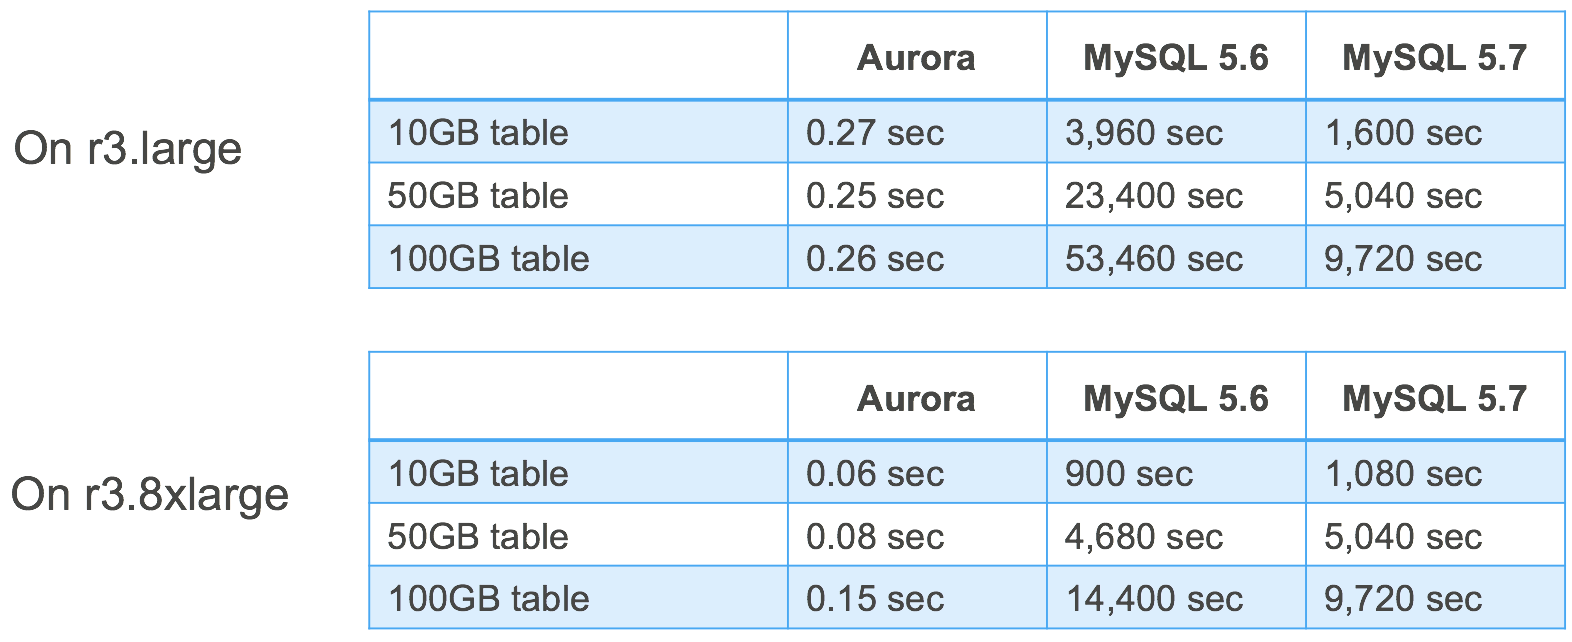

**aws에서 말하는 마무리 요약**

- 개선해야 할 많은 DDL 작업이 있지만 대부분의 작업을 동일한 방식으로 해결할 수 있다고 확신
 - 데이터베이스가 정상적인 가용성 범위 내에서 운영되고 있더라도, 장시간 수행되는 DDL 작업들로 인해 애플리케이션은 정상 수행될 수 없음
 - 병렬, 백그라운드 및 비동기 방식 실행이 차별점
